# <center>Group Project for Data Driven Decision Making</center>

------
## Import module, library, and data
I used the updated Cityline data with over 50,000 entries.

In [ ]:
import pandas as pd
import numpy as np
import datetime
import re
from IPython.display import display, HTML 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 

In [ ]:
dfc = pd.read_csv(r'Data/original/Cityline_Calls_for_Service_New.csv')
dfc_trash=dfc.loc[dfc['complaint_type_name'].str.contains('[Tt]rash')]
dfc_trash['complaint_type_name'].value_counts()

## Cityline 
+ Illegal Trash Set Out: 5645
+ Trash Skip: 2444
+ Trash Can Taken / Damaged: 13
+ Trash/Debris-Private, Occ: 2
+ Total: 8104 entries contain the word `Trash` in complaint type
<br>`Trash Can Taken / Damaged` seems unrelated to trash itself but more like a theft so I will drop them. After removal, 8089 entires are about trash.

In [ ]:
dfc_trash=dfc_trash.loc[dfc_trash['complaint_type_name'].str.contains('Damaged')==False].loc[dfc_trash['complaint_type_name'].str.contains('Private')==False]
dfc_trash['complaint_type_name'].value_counts()

### Check Address

After removing `&`, `To`, and `At`, 6537 entries have clean address

In [ ]:
#dfc_trash_address = dfc_trash[dfc_trash['address'].str.contains('&')==False]
dfc_trash_address = dfc_trash[(dfc_trash['address'].str.contains(' [Tt][Oo] ')==False) & 
                              (dfc_trash['address'].str.contains(' [Aa][Tt] ')==False) &
                              (dfc_trash['address'].str.contains('&')==False)]
#dfc_trash_address = dfc_trash_address
dfc_trash_address['address'].count()
dfc_trash_address.info()

#### Result: 6537 entries have correct address and are about trash.
-----
### Address Cleanup
#### 1. Check the last word in address.

In [ ]:
dfc_add_check = dfc_trash_address['address'].str.extract('\s([A-Za-z]*$)')
dfc_add_check[0].sort_values().unique()

#### 2. Strip Rear from address
Other than the street name abbreviation, `Rear` seems odd and not really a part of address. I googled the address and `Rear` is not really a part of the address. 

In [ ]:
dfc_trash_address.loc[dfc_trash_address['address'].str.contains(' Rear$'),'address']=dfc_trash_address['address'].str.replace(' Rear$','')
dfc_add_check = dfc_trash_address['address'].str.extract('\s([A-Za-z]*$)')
dfc_add_check[0].sort_values().unique()

#### 3. Change NSEW to Full name and move it up front

In [ ]:
dfc_trash_address.loc[dfc_trash_address['address'].str.contains(' N$'),'address'] = 'North '+dfc_trash_address['address'].str[:-2]
dfc_trash_address.loc[dfc_trash_address['address'].str.contains(' S$'),'address'] = 'South '+dfc_trash_address['address'].str[:-2]
dfc_trash_address.loc[dfc_trash_address['address'].str.contains(' E$'),'address'] = 'East '+dfc_trash_address['address'].str[:-2]
dfc_trash_address.loc[dfc_trash_address['address'].str.contains(' W$'),'address'] = 'West '+dfc_trash_address['address'].str[:-2]

In [ ]:
dfc_add_check = dfc_trash_address['address'].str.extract('\s([A-Za-z]*$)')
dfc_add_check[0].sort_values().unique()

#### 4. Notice `King`, `Green`, and `Tnpk` as the last word
Kinda weird so I pull out the info to check.
* `King` is `Martin Luther King`, which is a street name.
* `Green` is `Academy Greeg`, which is an address.
* `Tnpk` stands for `Turnpike`

In [ ]:
dfc_add_check = dfc_trash_address.loc[(dfc_trash_address['address'].str.contains('King$')) |
                                      (dfc_trash_address['address'].str.contains('Green$'))|
                                      (dfc_trash_address['address'].str.contains('Tnpk$'))]
dfc_add_check['address'].sort_values().unique()

#### 5. Replace the Abbreviation with Full Street Name.

In [ ]:
dfc_trash_address['address']=dfc_trash_address['address'].str.replace(' Ave$',' Avenue'
                                                                     ).str.replace(' Blvd$',' Boulevard'
                                                                     ).str.replace(' Cir$',' Circle'
                                                                     ).str.replace(' Ct$',' Court'
                                                                     ).str.replace(' Dr$',' Drive'
                                                                     ).str.replace(' Ext$',' Extension',
                                                                     ).str.replace(' Ln$',' Lane'
                                                                     ).str.replace(' Pk$',' Park'
                                                                     ).str.replace(' Pkwy$',' Parkway'
                                                                     ).str.replace(' Pl$',' Place'
                                                                     ).str.replace(' Rd$',' Road'
                                                                     ).str.replace(' Sq$',' Square'
                                                                     ).str.replace(' St$',' Street'
                                                                     ).str.replace(' Terr$',' Terrace'
                                                                     ).str.replace(' Tnpk$',' Turnpike'
                                                                     ).str.replace(' Luthr ',' Luther ')

#### 6. Combine street number with capitalised address

In [ ]:
dfc_trash_address['street_address']=dfc_trash_address['number']+' '+dfc_trash_address['address'].str.upper()

In [ ]:
dfc_trash_address['street_address'].count()

## Done for Cityline Address

-------
## Parcel Data

In [ ]:
dfp = pd.read_csv(r'Data/original/Parcel_Data_April_2018.csv')
#dfp.info()

#### 1. Clean up weird address

In [ ]:
dfp.loc[dfp['FullName'].str.contains('&'), 'FullName'] = dfp['FullName'].str.extract('(.*)&')[0]
dfp.loc[dfp['FullName'].str.contains(' & '), 'FullName'] = dfp['FullName'].str.extract('(.*) & ')[0]
dfp.loc[dfp['FullName'].str.contains(' TO '), 'FullName'] = dfp['FullName'].str.extract('(.*) TO ')[0]
dfp.loc[dfp['FullName'].str.contains(' AT '), 'FullName'] = dfp['FullName'].str.extract('(.*) AT ')[0]
dfp.loc[dfp['FullName'].str.contains(' $'), 'FullName'] = dfp['FullName'].str.extract('(.*) $')[0]
dfp.loc[dfp['FullName'].str.contains(' REAR'), 'FullName'] = dfp['FullName'].str.extract('(.*) REAR')[0]
dfp.loc[dfp['FullName'].str.contains(' R '), 'FullName'] = dfp['FullName'].str.extract('(.*) R')[0]
dfp.loc[dfp['FullName'].str.contains(' $'), 'FullName'] = dfp['FullName'].str.extract('(.*) $')[0]
dfp.loc[dfp['FullName'].str.contains(' SIDE$'), 'FullName'] = dfp['FullName'].str.extract('(.*) SIDE$')[0]
dfp.loc[dfp['FullName'].str.contains('114 SABINE'), 'FullName'] = dfp['FullName'] + ' ST'
dfp.loc[dfp['FullName'].str.contains('194 CHAFFEE'), 'FullName'] = dfp['FullName'] + ' ST'
#dfp['FullName'].unique().tolist()

#### 2. Check the last word of the address

In [ ]:
dfp_add_check = dfp['FullName'].str.extract('\s([A-Za-z]*$)')
dfp_add_check[0].sort_values().unique()
#display(HTML(dfp_add_check.head(1).to_html()))

#### 3. Check the weird address

In [ ]:
dfp_add_check = dfp[(dfp['FullName'].str.contains('SABINE$')==True) |
                    (dfp['FullName'].str.contains('SIDE$')==True)]
display(HTML(dfp_add_check.head(1).to_html()))
dfp_add_check['FullName'].unique().tolist()

#### 4. Move Direction NSEW to Front

In [ ]:
dfp.loc[dfp['FullName'].str.contains(' E$'),'FullName']=dfp['FullName'].str.extract('([^A-Z]*) ')[0]+' EAST '+dfp['FullName'].str.extract('[^A-Z]* (.*) [A-Z]$')[0]
dfp.loc[dfp['FullName'].str.contains(' W$'),'FullName']=dfp['FullName'].str.extract('([^A-Z]*) ')[0]+' WEST '+dfp['FullName'].str.extract('[^A-Z]* (.*) [A-Z]$')[0]
dfp.loc[dfp['FullName'].str.contains(' N$'),'FullName']=dfp['FullName'].str.extract('([^A-Z]*) ')[0]+' NORTH '+dfp['FullName'].str.extract('[^A-Z]* (.*) [A-Z]$')[0]
dfp.loc[dfp['FullName'].str.contains(' S$'),'FullName']=dfp['FullName'].str.extract('([^A-Z]*) ')[0]+' SOUTH '+dfp['FullName'].str.extract('[^A-Z]* (.*) [A-Z]$')[0]

In [ ]:
dfp_add_check = dfp['FullName'].str.extract('\s([A-Za-z]*$)')
dfp_add_check[0].sort_values().unique()

#### 5. Change Abbrieviation to Full Name

In [ ]:
dfp['FullName']=dfp['FullName'].str.replace(' AVE*$',' AVENUE').str.replace(' ALY$',' ALLEY'
                              ).str.replace(' BLVD$',' BOULEVARD').str.replace(' BRG$',' BRIDGE').str.replace(' CIR$',' CIRCLE'
                              ).str.replace(' CT$',' COURT').str.replace(' DR$',' DRIVE' ).str.replace(' EXT$',' EXTENSION',
                              ).str.replace(' GRN$',' GREEN').str.replace(' L[AN]$',' LANE').str.replace(' PK$',' PARK'
                              ).str.replace(' PKWY$',' PARKWAY').str.replace(' PL$',' PLACE').str.replace(' RD$',' ROAD'
                              ).str.replace(' SQ$',' SQUARE').str.replace(' ST$',' STREET').str.replace(' TER+$',' TERRACE'
                              ).str.replace(' TNPK$',' TURNPIKE')

In [ ]:
dfp_add_check = dfp['FullName'].str.extract('\s([A-Za-z]*$)')
dfp_add_check[0].sort_values().unique()

------

### RECAP!
Until now, I have 
1. `dfc_trash_address`: Cityline dataframe with cleaned and capitalised address that is combined with street number in a column named `street_address`
2. `dfp`: Parcel dataframe with cleaned address in a column called `FullName`
------
### Merge 1: Parcel with Cityline
#### 1. Drop `Parcel FullName` Duplicates
Because I am merging `Cityline` `street_address` with `Parcel` `FullName` column to get the `CensusTrac` for future merging with demographic data, given that the same address always has the same census tract, I will drop the duplicated `FullName` in `Parcel` in the merging process. The merged dataframe will be called, unsurprisingly, `dfm`.
+ `pd.merge`: Panda merge function
+ `dfc_trash_address`: Dataframe on the left
+ `dfp.drop_duplicates('FullName')`: df on the right with duplicated `FullName` dropped
+ `left_on`: the column to merge on the left, cityline
+ `right_on`: above
+ `how = 'left'`: left merge, meaning everything in `Cityline` will still be in `dfm` whether the `street_address` is matched with a `FullName` or not so there will be some rows contain info from both `Cityline` and `Parcel` and some only has info from `Cityline`. For `Parcel`, if none of the `street_address` can match, the rows are **NOT** included.
+ `validate = 'm:1'`: Left, `Cityline street_address`, can have multiple rows with the same value (address) and right, `Parcel FullName`, has to be unique. 
### Result: 6500 rows from Cityline were matched.

In [ ]:
dfm = pd.merge(dfc_trash_address,
               dfp.drop_duplicates('FullName'),
               left_on = 'street_address',
               right_on = 'FullName',
               how = 'left',
               validate = 'm:1',
               indicator = True)
dfm['_merge'].value_counts()

#### 2. Take a look
2-1:<br>
Now 6500 addresses from `Cityline Trash` has a `CensusTrac` and will be used to merge with demographics data to obtain information

In [ ]:
display(HTML(dfm.head(1).to_html()))

2-2:<br>
Take a look at the `CensusTrac` and oh no it's a mess

In [ ]:
dfm['CensusTrac'].sort_values().unique()

2-3:<br>
Because without the workshop in the class, I don't know what it should look like.<br>Load the demographic data into `dfd` and check the format

In [ ]:
dfd = pd.read_csv(r'Data/original/1216_ACS.csv', dtype={'FIPS': 'str'})
dfd['FIPS'].sort_values().unique()

#### 3. Clean up `dfm` CensusTrac

In [ ]:
dfm['CensusTrac']=dfm['CensusTrac'].str.replace('Null','0').astype(float)*100
dfm['CensusTrac']=dfm['CensusTrac'].fillna(0).astype(int).astype(str).str.zfill(6)
dfm['FIPS'] = '36067' + dfm['CensusTrac']
dfm['FIPS'].sort_values().unique()

### Cool. Now the `FIPS` in `dfm` is the same format as `FIPS` in `dfd`
However, look at the 2 output above, `dfd` contains way more `FIPS` than `dfm`. The purpose of `dfct`? Because `dfd` contains all tract information from the entire county but we only care about Syracuse. `dfct` gives me census information about Syracuse only.
+ `dfd` has 140 FIPS code and `dfm` has 54 only.
+ After merging, `dfct` has 53 FIPS code from both.
-----
### Merge 2: Filter out demographic info for Syracuse only

In [ ]:
dfct = pd.merge(dfd,
                dfm.drop_duplicates('FIPS')[['FIPS','complaint_number']],
                on = 'FIPS',
                how = 'inner',
                validate = '1:1',
                indicator = True
               )
dfct['_merge'].value_counts()
#dfct = dfct[dfct['_merge'] == "both"]

In [ ]:
display(HTML(dfct.head(1).to_html()))

----
### Merge 3: Now `dfm` from Parcel & Cityline Merges with `dfct` demographic info about Syracuse and make `df`

In [ ]:
df = pd.merge(dfm.drop(columns=['_merge']), 
              dfct.drop(columns=['_merge', 'complaint_number']), 
              on = 'FIPS', 
              how = 'left', 
              validate = "m:1", 
              indicator = True 
             )
df['_merge'].value_counts()

### Result: 6,497 matches!
Why do 40 entries have no match (left_only)? Because their `CensusTrac` is 0 and `FIPS` is 36067000000.
<br>Originally, in `Parcel`, their `CensusTrac` is either `Null` or `nan`. Why? Idk

In [ ]:
display(HTML(df.head(1).to_html()))

In [ ]:
df.to_csv('data/working/df.csv')

-----
# Recap
1. `dfc_trash_address`: Cityline. 8,089 entries about Trash, not including Bin stolen, and **6,537** of them have clean address (not `&`,`To`,`At`,etc in the address). The information we need to perform merge is in `street_address` column. 
<br><font color='red'>**Problems:**</font> Around 1,500 were lost in address cleaning process, how can we reduce the loss in this process??<br>

2. `dfp`: Parcel Data. Not particularly useful, but has both address and censustract so it's used as a bridge to connect cityline and demographic. The address information to match with `Cityline` is called `FullName` and the CensusTract info for demographics is called `CensusTrac`
<br><font color='red'>**Problems:**</font> Same thing. For Parcel I didn't particularly take note about the number of address removed in the process.<br>
3. `dfm`: Merged dataframe of Cityline and Parcel. **6,500** out of the 6,537 are matched. However, the `CensusTrac` is messy so it has to be cleaned and put into `FIPS` to further merge with `dfd`.
<br><font color='red'>**Problems:**</font> Why are there `Null` or `nan` in CensusTrac????<br>Also, 37 from cityline have no match in Parcel, if we improve the previous questions, perhaps we can obtain more.
4. `dfct`: Very similar to `dfd`, but only contains the tract info about Syracuse. There are **53 CensusTract** in Syracuse about trash
<br><font color='red'>**Problems:**</font> But this is based on the dfm, what if some tract neighbourhood have no complaints or parcels?<br>
5. `df`: Final, hopefully, dataframe. Out of the 6,537 from the cityline trash, **6,493** now have information from Parcel and from demographic. **7** have parcel and cityline. **40** have only Cityline, I think. Not sure.<br>df has **6,537** entries and **296** columns

In [ ]:
df.info()

--------
# Ideas
## 1. Complaint timing: Just the time of the complaint, nothing about the close time yet.

In [82]:
import calendar
df['open_date']=pd.to_datetime(df['open_date'])
df['open_month']=df['open_date'].dt.month
df['open_month_name']=df['open_month'].apply(lambda x: calendar.month_abbr[x])
df['open_month_name'].value_counts()

May    809
Mar    717
Apr    662
Jan    659
Feb    612
Oct    500
Jun    491
Aug    487
Jul    468
Sep    423
Nov    374
Dec    335
Name: open_month_name, dtype: int64

### 1-1. Complaint count distribution

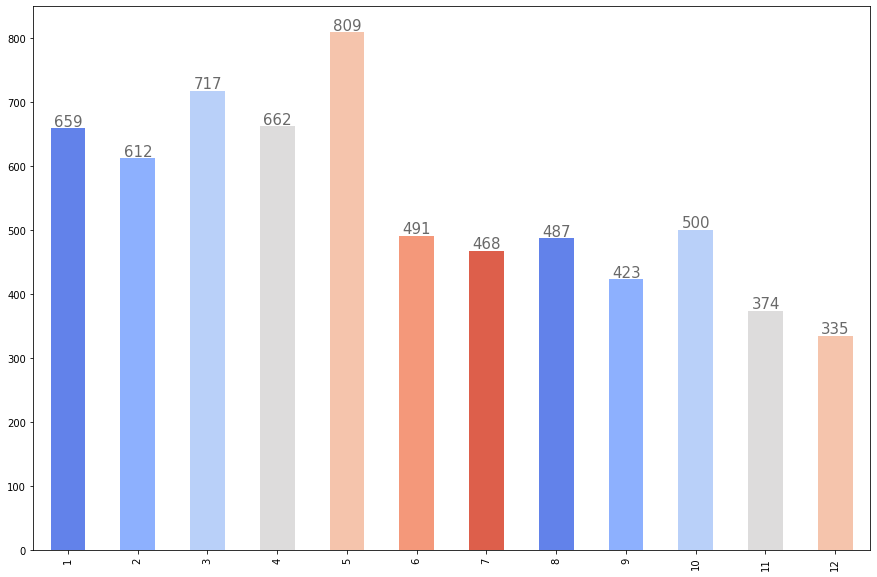

In [74]:
ax = df['open_month'].value_counts().sort_index().plot(kind='bar',
                                                       figsize=(15,10),
                                                       color=sns.color_palette("coolwarm", 7))

# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_height())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x()+.05, i.get_height()+3.95, \
            str(i.get_height()), fontsize=15,
                color='dimgrey')

### <font color='red'>**Problems:**</font>
1. If I use `plt.yticks()` to change the intergers on x-axis to month name, the positions are messed up.
2. If I change the number to name in dataframe, sorted index is alphabetically ordered.

In [ ]:
ax = sns.scatterplot(x='TNT_NAME', y='open_month',data=df,
                     )